## Beamforming, but using a database of precomputed noise correlations

### This notebook is very similar to "1_Basic_beamforming.ipynb", with the exception of using correlation waveforms instead of raw timeseries.
### Compare for yourself, the results should be *identical*!
### Note also - any correlation processing flags in "/INPUT/processing.txt" will also be effectively applied to the noise correlations. We include no preprocessing by default, but emphasize that you *could* explore the effects of preprocessing this way.

In [6]:
# Python 3.7

import sys
sys.path.append('../GI1_v0.2.1')
sys.path.append('../GI1_v0.2.1/PLOT/')
sys.path.append('../GI1_additions')


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import green as g
import source as s
import processing as proc
import parameters
import time
import random
from correlation_random import *
from correlation_function import *
from correlation_field import *
from kernels import *
from adsrc import *
from earthquakes import *

# The following are newly added, as compared to the original GI code.
from generate_random_signals import *
from specshift import *

%matplotlib inline

In [7]:
mpl.rcParams['figure.figsize'] = [20, 10]

In [8]:
## Check the station and noise-source geometry
# S,indeces=s.space_distribution(plot=1)

In [9]:
use_saved_data = True

#####################################################
if(use_saved_data is False):
    
    # Check the station and noise-source geometry
    S,indeces=s.space_distribution(plot=1)


    # Re-create the synthetic data.
    ut,traw,cct,tt_corr,ccf,f = generate_random_signals(verbose=False,plot=True,save=True,return_cc=True)
#####################################################
else:
    # Alternatively, just load from file
    p=parameters.Parameters()

    # Load "traw" of raw timeseries
    filename = './OUTPUT/raw_synthetics/traw.npy'
    traw = np.load(filename)
    
    # Load raw timeseries
    for i in range(p.Nreceivers):
        filename = './OUTPUT/raw_synthetics/syn_{0}.npy'.format(i)
        if(i==0): # first one, load to get size.
            tmp = np.load(filename)
            [nsamp,nwindows] = np.shape(tmp)
            ut = np.zeros([nsamp,nwindows,p.Nreceivers])
            ut[:,:,i] = tmp
        else:
            ut[:,:,i] = np.load(filename)
    
    # Load "t" of correlations functions
    filename = './OUTPUT/correlations_measured/t.npy'
    tt_corr = np.load(filename)
    nt = np.size(tt_corr)

    # Load correlation functions
    cct = np.zeros([nt,p.Nwindows,p.Nreceivers**2])
    counter = 0
    for i in range(p.Nreceivers):
        for j in range(p.Nreceivers):        
            filename = "./OUTPUT/correlations_measured/cct_proc_{}_{}.npy".format(i,j)
            this_corr = np.load(filename)

            cct[:,:,counter] = this_corr
            counter += 1
#####################################################

# Ideally one might stack correlations from multiple time windows if they existed, 
#  but default parameters is to have only one anyways.
iwin=0
correlations = cct[:,iwin,:]


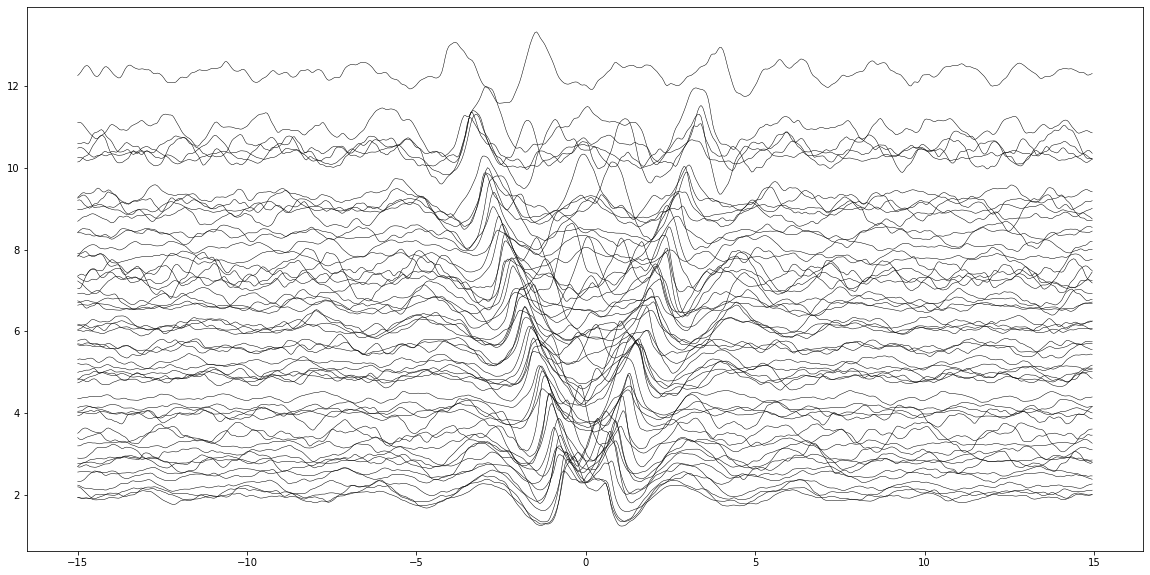

In [11]:
# Plot record section of the noise correlations
p = parameters.Parameters()

counter = 0
xx = p.x/1000.0
yy = p.y/1000.0

for i in range(p.Nreceivers):
    for j in range(p.Nreceivers):
        if(i<j): # Only plot one direction, don't need both for this plot
            total_distance = np.sqrt( (xx[i]-xx[j])**2 + (yy[i]-yy[j])**2 )
            this_corr = correlations[:,counter]
            this_corr = this_corr / np.max(this_corr)
            plt.plot(tt_corr, this_corr + total_distance,'k', linewidth=.5)
        counter += 1
        
plt.show()

In [12]:
# Beamform, but using the correlations

#- Input parameters.
p = parameters.Parameters()
xx = p.x/1000
yy = p.y/1000

# Define a grid of slownesses to test
# TODO - load this from parameters instead of hardcode?
# max-slowness:
sl = .75 # second/km

# (green's functions programmed at 3000m/s -> 0.33s/km)
# number of pixes in x and y
nux = 101
nuy = 101
ux = np.linspace(-sl,sl,nux)
uy = np.linspace(-sl,sl,nuy)
dux = np.abs(ux[1]-ux[0])
duy = np.abs(uy[1]-uy[0])

# Define the index of actual noise source, for verification
# (as defined in source.py)
expected_slowness = 1/3.0
sx = expected_slowness*np.sqrt(2)/2
sy = expected_slowness*np.sqrt(2)/2
ix0 = (np.abs(ux-sx)).argmin()
iy0 = (np.abs(uy-sy)).argmin()

P = np.zeros([nux,nuy])


counter_grid = 0
print("starting gridpoints: {0}".format(nux*nuy))
for ix in range(0,nux):
        for iy in range(0,nuy):
                counter_grid+=1
                if(counter_grid % 1000 == 0):
                    print(counter_grid)
                 
                # For each station-station pair
                counter = 0
                for i in range(0,p.Nreceivers):
                    for j in range(0,p.Nreceivers):
                        
                        # Ignore auto-correlations
                        if(i==j):
                            counter += 1
                            continue
                            
                        # Distance vector (in km)
                        distance_x = xx[i]-xx[j]
                        distance_y = yy[i]-yy[j]
                        
                        # effective time, i.e., where signal in correlation shows up
                        time_effective = -ux[ix]*distance_x -uy[iy]*distance_y
                        
                        index_time = (np.abs(tt_corr - time_effective)).argmin()
                        P[ix,iy] += correlations[index_time,counter]

                        counter += 1
print("Done.")
np.save('2_P', P)


starting gridpoints: 10201
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Done.


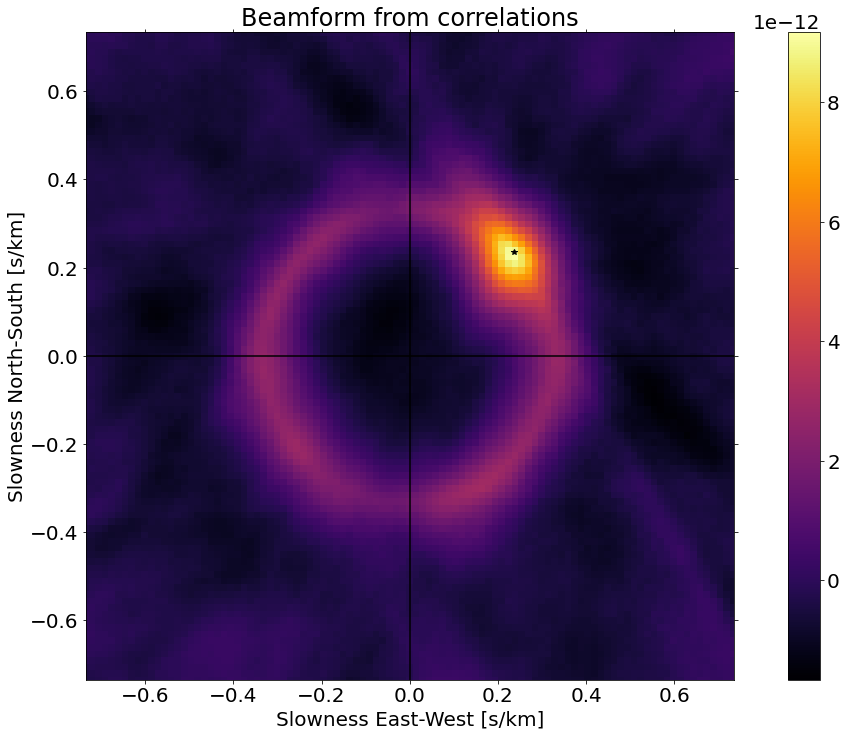

In [13]:
mpl.rc('font', **{'size':20})

def plot_beam(P, title="Beamform",save=0,savename='none',cmax=0):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_axes([0.1,0.1,0.6,0.6])  #x0,y0,dx,dy
    cmap = plt.get_cmap('inferno')
    i = plt.pcolor(ux-dux/2,uy-duy/2,np.real(P.T),cmap=cmap,rasterized=True)#,vmin=-4,vmax=4)
    if(cmax==0):
        cmax=np.max(np.abs(P))
    cmin=np.min(P)
    plt.clim(cmin, cmax)
    
    plt.axis('equal')
    plt.axis('tight')
    plt.xlim(min(ux)+dux,max(ux)-dux)
    plt.ylim(min(uy)+duy,max(uy)-duy)
    plt.xlabel('Slowness East-West [s/km]')
    plt.ylabel('Slowness North-South [s/km]')
    ax.tick_params(top=True,right=True)
    plt.plot(sx,sy,'k*')
    plt.plot([np.min(ux), np.max(ux)],[0,0],'k')
    plt.plot([0,0],[np.min(uy), np.max(uy)],'k')
    plt.title(title)
    colorbar_ax = fig.add_axes([0.75, 0.1, 0.03, 0.6])  #x0,y0,dx,dy
    fig.colorbar(i, cax=colorbar_ax)
    if(save==1):
        plt.savefig(savename, bbox_inches='tight')
    plt.show()



plot_beam(P, title="Beamform from correlations", 
          save=True, savename="2_correlation_beamform_square")

### Now, transform to polar axis and plot on a circular grid.
### We find this is somewhat more intuitive for readers; it is easier to understand that this is pointing out towards different directions when it looks like a compass. 
### Note - a better algorithm might define the slowness domain on polar coordinates from the very beginning. This would require reorganizing the for-loops in the algorithm above, to loop through values of theta and r. 

In [16]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

UX, UY = np.meshgrid(ux, uy)
UR = np.zeros_like(UX)
UT = np.zeros_like(UY)
for iux in range(nux):
    for iuy in range(nuy):
#         UR[iux, iuy], UT[iux, iuy] = cart2pol(UX[iux, iuy], UY[iux, iuy])
        UR[iux, iuy], UT[iux, iuy] = cart2pol(UX[iux, iuy]-dux/2, UY[iux, iuy]-duy/2)
        
SR, ST = cart2pol(sx, sy)


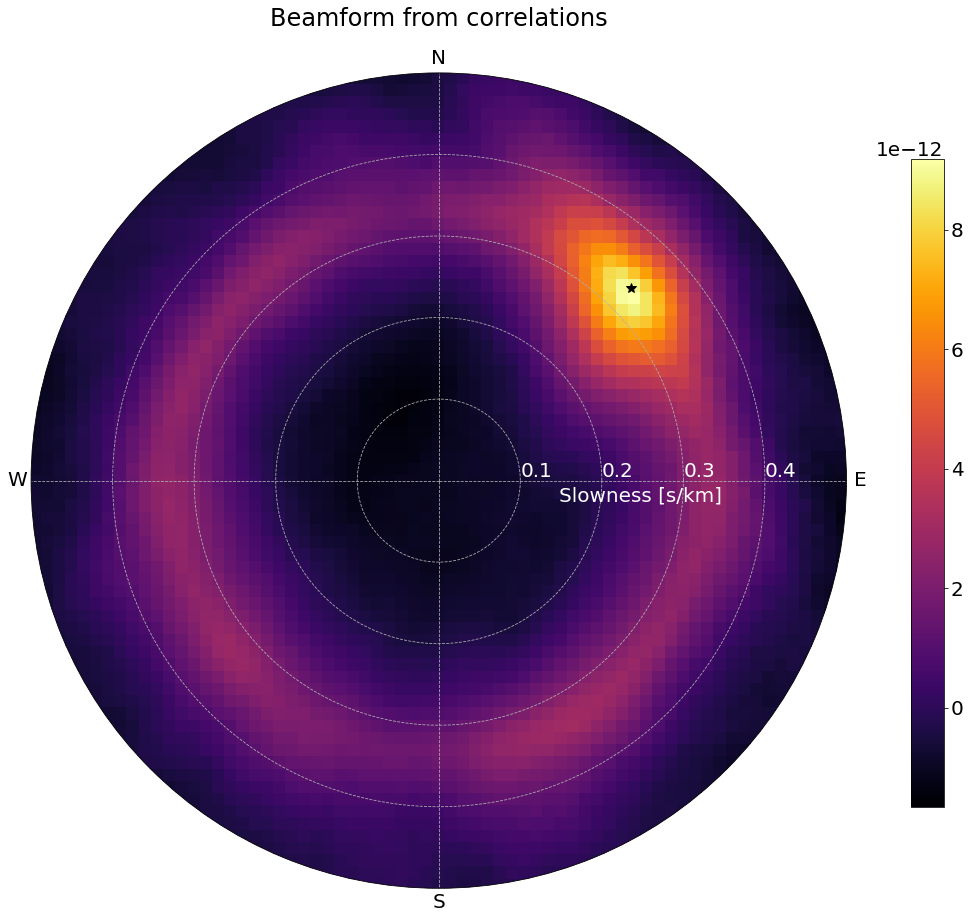

In [17]:
mpl.rc('font', **{'size':20})
    
def plot_beam_polar(P, title="Beamform",save=0,savename='none',cmax=0):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, polar = True)
    cmap = plt.get_cmap('inferno')
    i = plt.pcolor(2*np.pi-UT[::1]+np.pi/2, UR[::1], np.real(P[::1]), cmap=cmap, rasterized=True)
    
    if(cmax==0):
        cmax=np.max(np.abs(P))
    cmin=np.min(P)
    plt.clim(cmin, cmax)
    
    # set title, labels, etc
    plt.title(title)
    
    ax.set_xticks(np.arange(0, 2.0*np.pi, np.pi/2.0))
    ax.set_xticklabels(["E", "N", "W", "S"])
    ax.tick_params(axis='x', colors='black', grid_linestyle='--')
    
    ax.set_ylim(0,0.5)
    ax.set_yticks([0.1, 0.2, 0.3, 0.4])
    ax.tick_params(axis='y', colors='white', grid_linestyle='--')
    ax.text(np.radians(-10), 0.15, 'Slowness [s/km]', rotation=0, color="white")
    ax.set_rlabel_position(0)
    ax.grid(True)
    
    # plot expected blob
    plt.plot(ST, SR, 'k*', markersize=11)

    # colorbar
    colorbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])  #x0,y0,dx,dy
    fig.colorbar(i, cax=colorbar_ax)
    
    # save figure
    if(save==1):
        plt.savefig(savename, bbox_inches='tight')
    


plot_beam_polar(P,title="Beamform from correlations", save=1, savename="2_correlation_beamform_polar.pdf")
plt.show()

## Bonus: examining the windowing functions
### Often, noise inversion techniques and interferometry will restrict observations to a certain timewindow (i.e., surface waves). This is often necessary, especially with noisy data. However, it unfortunately throws away useful information. What happens when the strongest energy is coming in at some wierd time because of the station-pair geometry?

### First, restrict to surface wave window times and compare to the main signal's expected pick:

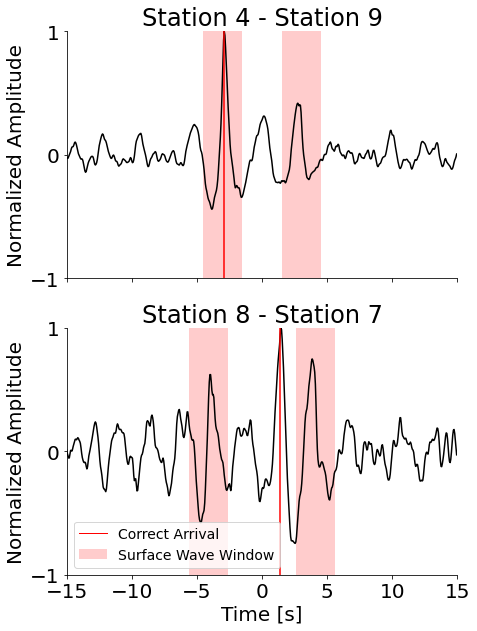

In [18]:
plot = True
velocity_surface_waves = 3.0
window_half_length = 1.5

def plot_correlations_and_windows_for_surfacewaves(selection, save=False, savename='none'):
    # "selection" is an array of station pairs like: selection = [(1, 2), ...] 
    # Assumes that the true source is known and defined by ux[ix0], uy[iy0]
    
    fig = plt.figure(figsize=(7,10))
    
    for i_plot in range(len(selection)):

        plt.subplot(2, 1, i_plot+1)

        counter = selection[i_plot][0]*p.Nreceivers + selection[i_plot][1]
        plt.plot(tt_corr, correlations[:, counter]/np.max(np.abs(correlations[:, counter])),'k')
        
        # Distance vector (in km)
        distance_x = xx[selection[i_plot][0]]-xx[selection[i_plot][1]]
        distance_y = yy[selection[i_plot][0]]-yy[selection[i_plot][1]]
        

        ax = plt.gca()
        boxes_surface_wave=[]
        time_surface_wave = np.sqrt(distance_x**2+distance_y**2) / velocity_surface_waves
        boxes_surface_wave.append(mpl.patches.Rectangle((-time_surface_wave-window_half_length, -1.0), 2*window_half_length, 2.0))
        boxes_surface_wave.append(mpl.patches.Rectangle((time_surface_wave-window_half_length, -1.0), 2*window_half_length, 2.0))
        pc_surface_wave = mpl.collections.PatchCollection(boxes_surface_wave, facecolor='r', alpha=0.2)
        ax.add_collection(pc_surface_wave)

        time_effective_for_correct_pick = -ux[ix0]*distance_x -uy[iy0]*distance_y                
        index_time = (np.abs(tt_corr - time_effective_for_correct_pick)).argmin()
        plt.plot([tt_corr[index_time],tt_corr[index_time]], [-1,1], 'r')

        
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)


        # 2-panel setup
        if i_plot == 0:
            ax.set_xticklabels([])
        if i_plot == 1:
            plt.xlabel("Time [s]")
            legend_elements=[mpl.lines.Line2D([0], [0], color='r', lw=1, label='Correct Arrival'),
                             #mpl.patches.Patch(facecolor='red', alpha=0.2, label='Selected Window')] #,
                             mpl.patches.Patch(facecolor='red', alpha=0.2, label='Surface Wave Window')]
            ax.legend(handles=legend_elements, fontsize=14)
        ax.spines['left'].set_visible(True)
        ax.set_yticks([-1.0, 0, 1.0])
        # ax.set_yticks([-1.0, -0.5, 0, 0.5, 1.0])
        plt.ylabel("Normalized Amplitude")
    
        plt.xlim(-15.0, 15.0)
        plt.ylim(-1.0, 1.0)
        
        # title?
        plt.title("Station {0} - Station {1}".format(selection[i_plot][0], selection[i_plot][1]))
    
    if save:
        plt.savefig(savename, bbox_inches='tight')
    plt.show()
    
    

selection = [(4, 9), (8, 7)]
plot_correlations_and_windows_for_surfacewaves(selection=selection, save=True, savename="2_correlations_surfacewavewindows.pdf")

### Now we go the other way: beamform, define a window of something interesting in slowness domain, and then window the correlations accordingly. 

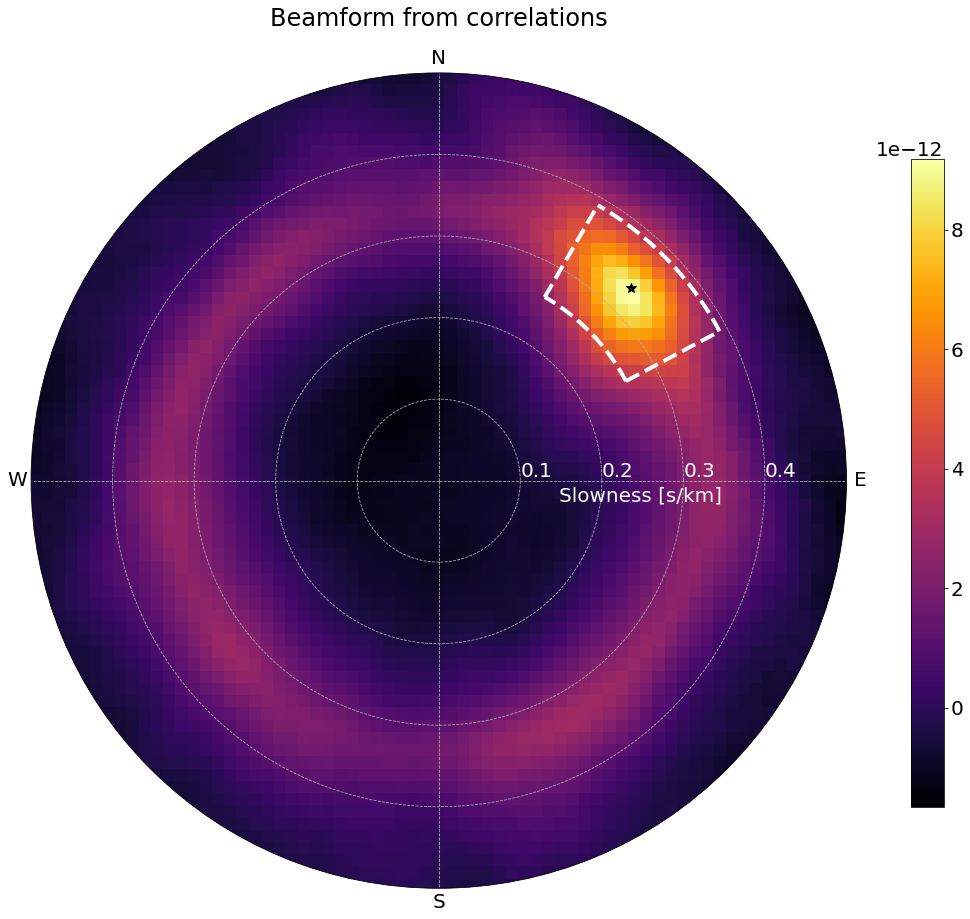

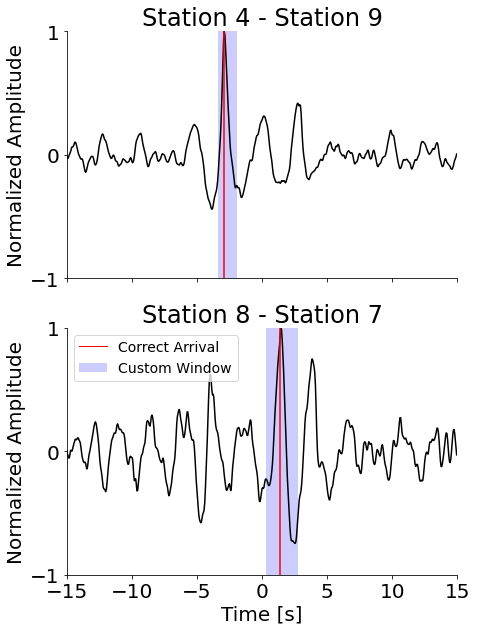

In [19]:
mpl.rc('font', **{'size':20})

def plot_beam_polar_with_window(P, title="Beamform",save=0,savename='beamform_with_window.pdf',cmax=0, 
                               angle1_deg = 0, angle2_deg=90, radius1=0.1, radius2=0.4):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, polar = True)
    cmap = plt.get_cmap('inferno')
    i = plt.pcolor(2*np.pi-UT[::1]+np.pi/2, UR[::1], np.real(P[::1]), cmap=cmap, rasterized=True)
    
    if(cmax==0):
        cmax=np.max(np.abs(P))
    cmin=np.min(P)
    plt.clim(cmin, cmax)
    
    ###################
    #- This is the only difference from the normal plotting function
    #- This will add the white box, the region to select
    angle1 = np.radians(angle1_deg)
    angle2 = np.radians(angle2_deg)
    thetas = np.linspace(angle1, angle2, 100)
    radius1 = 0.26   
    radius2 = 0.39
    radii1 = radius1 * np.ones_like(thetas)
    radii2 = radius2 * np.ones_like(thetas)
    plt.plot(thetas, radii1, "w--", linewidth=4)
    plt.plot(thetas, radii2, "w--", linewidth=4)
    plt.plot([angle1, angle1], [radius1, radius2], "w--", linewidth=4)
    plt.plot([angle2, angle2], [radius1, radius2], "w--", linewidth=4)
    ###################
    
    # set title, labels, etc
    plt.title(title)
    
    ax.set_xticks(np.arange(0, 2.0*np.pi, np.pi/2.0))
    ax.set_xticklabels(["E", "N", "W", "S"])
    ax.tick_params(axis='x', colors='black', grid_linestyle='--')
    
    ax.set_ylim(0,0.5)
    ax.set_yticks([0.1, 0.2, 0.3, 0.4])
    ax.tick_params(axis='y', colors='white', grid_linestyle='--')
    ax.text(np.radians(-10), 0.15, 'Slowness [s/km]', rotation=0, color="white")
    ax.set_rlabel_position(0)
    ax.grid(True)
    
    # plot expected blob
    plt.plot(ST, SR, 'k*', markersize=11)
    

    # colorbar
    colorbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])  #x0,y0,dx,dy
    fig.colorbar(i, cax=colorbar_ax)
    
    # save figure
    if(save==1):
        plt.savefig(savename, bbox_inches='tight')
    

    
#####################################################################################    
def plot_correlations_and_windows_for_window(selection, save=False, savename='correlation_with_window.pdf',
                                            angle1_deg = 0, angle2_deg=90, radius1=0.1, radius2=0.4):
    # "selection" is an array of station pairs like: selection = [(1, 2), ...] 
    # Assumes that the true source is known and defined by ux[ix0], uy[iy0]
    
    fig = plt.figure(figsize=(7,10))
    
    for i_plot in range(len(selection)):

        plt.subplot(2, 1, i_plot+1)

        counter = selection[i_plot][0]*p.Nreceivers + selection[i_plot][1]
        plt.plot(tt_corr, correlations[:, counter]/np.max(np.abs(correlations[:, counter])),'k')
        
        # Distance vector (in km)
        # i.e., for these two station pairs, the difference in distance x and in y. or theta and r.
        distance_x = xx[selection[i_plot][1]]-xx[selection[i_plot][0]]
        distance_y = yy[selection[i_plot][1]]-yy[selection[i_plot][0]]
        distance_r = np.sqrt(distance_x**2 + distance_y**2)
        direction_theta = np.arctan2(distance_y,distance_x)*180/np.pi
        

        
        # We want to know the minimum and maximum time-window for any signal that could fall in this box.
        # We will gridsearch through all points in the box and increase or decrease our time window bounds
        #  until we have found the time window that covers all possibilites.
        t_window_min = np.max(tt_corr)
        t_window_max = np.min(tt_corr)
        for itheta in np.arange(angle1_deg, angle2_deg, 1):
            for ir in np.arange(radius1, radius2, 0.01):
                # ir has units of slowness -> slowness [s/km] * distance [km] = time [s]
                # the angle theta requires a projection with cos()
                diff_theta = direction_theta - itheta
                time_effective = ir*distance_r*np.cos(diff_theta*np.pi/180)
                if time_effective < t_window_min:
                    t_window_min = time_effective
                if time_effective > t_window_max:
                    t_window_max = time_effective


        
        ax = plt.gca()
        boxes=[]
        # Define a rectangle by Rectangle((left,bottom),width,height)
        boxes.append(mpl.patches.Rectangle((t_window_min, -1.0), t_window_max-t_window_min, 2.0 ))
        pc = mpl.collections.PatchCollection(boxes,facecolor='b',alpha=0.2)
        ax.add_collection(pc)
        
        # Since we know where the source is, we can draw a red line where we expect the energy to arrive
        time_effective_for_correct_pick = ux[ix0]*distance_x +uy[iy0]*distance_y                
        index_time = (np.abs(tt_corr - time_effective_for_correct_pick)).argmin()
        plt.plot([tt_corr[index_time],tt_corr[index_time]], [-1,1], 'r')

        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)


        # 2-panel setup
        if i_plot == 0:
            ax.set_xticklabels([])
        if i_plot == 1:
            plt.xlabel("Time [s]")
            legend_elements=[mpl.lines.Line2D([0], [0], color='r', lw=1, label='Correct Arrival'),
                             mpl.patches.Patch(facecolor='blue', alpha=0.2, label='Custom Window')]
            ax.legend(handles=legend_elements, fontsize=14)
        ax.spines['left'].set_visible(True)
        ax.set_yticks([-1.0, 0, 1.0])
        # ax.set_yticks([-1.0, -0.5, 0, 0.5, 1.0])
        plt.ylabel("Normalized Amplitude")
    
        plt.xlim(-15.0, 15.0)
        plt.ylim(-1.0, 1.0)
        
        # title?
        plt.title("Station {0} - Station {1}".format(selection[i_plot][0], selection[i_plot][1]))
    
    if save:
        plt.savefig(savename, bbox_inches='tight')
    plt.show()
    
    
##################################################################################
angle1_deg=28.0 # defined in math way, counter-clockwise from East.
angle2_deg=60.0
radius1=0.26
radius2=0.39

selection = [(4, 9), (8, 7)]


plot_beam_polar_with_window(P,title="Beamform from correlations", save=True, savename="2_beamform_customwindow.pdf",
                           angle1_deg=angle1_deg, angle2_deg=angle2_deg, radius1=radius1, radius2=radius2)


plot_correlations_and_windows_for_window(selection=selection, save=True, savename="2_correlations_customwindow.pdf",
                            angle1_deg=angle1_deg, angle2_deg=angle2_deg, radius1=radius1, radius2=radius2)

